# Preparing datasets from the Sistema de Informação sobre Mortalidade (SIM) provied by the Ministério da Saúde
## Source: https://opendatasus.saude.gov.br/fa_IR/dataset/sim

In [1]:
import pandas as pd
from datetime import datetime

## Loading data

In [2]:
usecols = [2, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 28, 29, 34, 40,41,42,43, 44, 45, 46, 47, 48, 46, 48, 54, 55, 56, 63, 64, 65, 66, 69, 71, 72, 74, 75, 76, 78, 79, 81, 83, 85, 86]

my_list = ['str'] * len(usecols)

dtype = {key: value for key, value in zip(usecols, my_list)}

In [3]:
CID_CORONAVIRUS = 'B342'
CID_DIAGNOSIS_VIRUS_IDENTIFIED = 'U071'
CID_DIAGNOSIS_VIRUS_NOT_IDENTIFIED = 'U072'
CID_POST_COVID = 'U099'
CID_POST_COVID_MUTISYSTEM_INFLAMATORY_SYNDROME = 'U109'
CID_RECURRENCE = 'U921'

In [4]:
df = None
for filename in ['Mortalidade_Geral_2020.csv', 'Mortalidade_Geral_2021.csv']:
    df_temp = pd.read_csv('data/input/'+filename, header=0, sep=';', usecols=usecols, dtype=dtype)
    df_temp = df_temp[(df_temp['CAUSABAS'].str.contains(CID_CORONAVIRUS))].copy()
    if df is None:
        df = df_temp
    else:
        df = pd.concat([df, df_temp])

df_temp = pd.read_csv('data/input/Mortalidade_Geral_2022_previa.csv', header=0, sep=';', dtype='str')
columns = [item for item in df.columns if item not in ['CONTADOR']] + ['contador']
df_temp = df_temp[columns]
df_temp = df_temp[(df_temp['CAUSABAS'].str.contains(CID_CORONAVIRUS))].copy()

In [5]:
df_temp = df_temp.rename(columns={'contador': 'CONTADOR'})
df = pd.concat([df, df_temp])

In [6]:
df.shape

(700955, 42)

In [7]:
df[['DTOBITO','CAUSABAS','CAUSABAS_O','ATESTADO']]

,DTOBITO,CAUSABAS,CAUSABAS_O,ATESTADO
3,21052020,B342,B342,B342 U071/J960/J180*J440
9,27052020,B342,B342,B342 U071/J159*B342 U071
10,27052020,B342,U049,/J159/B342 U071 U049*I471
16,05052020,B342,B342,A419/J189/B342 U071
34,25052020,B342,B342,J80/B342 U071/N179
...,...,...,...,...
1506840,31122022,B342,B342,B342 U072/F03*D469 N039
1506888,31122022,B342,B342,G931/J189/B342 U071
1506897,31122022,B342,B342,B342 U071/J984/J159
1507025,13012022,B342,NaN,I219/B342 U071


In [8]:
date_columns = ['DTOBITO','DTATESTADO', 'DTNASC', 'DTCADASTRO', 'DTRECEBIM', 'DTRECORIGA','DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTINVESTIG']
df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%d%m%Y')

df['DIFDATA'] = df.DIFDATA.astype(int)

df['DIFDATA_CADASTRO_OBITO'] = (df.DTCADASTRO - df.DTOBITO).dt.days
df['DIFDATA_CADASTRO_ATESTADO'] = (df.DTCADASTRO - df.DTATESTADO).dt.days
df['DIFDATA_ATESTADO_OBITO'] = (df.DTATESTADO - df.DTOBITO).dt.days

In [9]:
df_municipal_base = pd.read_csv('data/input/df_municpal.csv')[['MUNICIPIO','CODIGO_MUNICIPIO_6','SIGLA_ESTADO','ESTADO','REGIAO','POPULACAO_2022']]

## Treating anomalies

<Axes: >

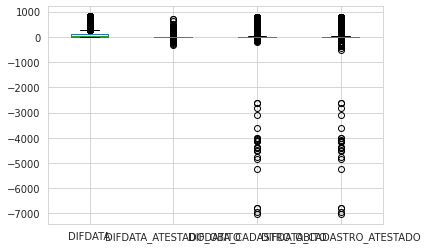

In [10]:
df.boxplot(column=['DIFDATA', 'DIFDATA_ATESTADO_OBITO', 'DIFDATA_CADASTRO_OBITO', 'DIFDATA_CADASTRO_ATESTADO'],figsize=(12,4))

In [11]:
df.DIFDATA_ATESTADO_OBITO.describe()

count    700140.000000
mean          0.267566
std           5.596147
min        -304.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         730.000000
Name: DIFDATA_ATESTADO_OBITO, dtype: float64

In [12]:
df[df.DIFDATA_ATESTADO_OBITO!=0][['DTOBITO','DTATESTADO','DTCADASTRO','DTRECEBIM','DIFDATA', 'DIFDATA_ATESTADO_OBITO']]

,DTOBITO,DTATESTADO,DTCADASTRO,DTRECEBIM,DIFDATA,DIFDATA_ATESTADO_OBITO
74,2020-05-26,2020-05-27,2020-06-15,2020-06-22,27,1.0
1712,2020-06-20,2020-06-22,2020-07-06,2020-07-17,27,2.0
1727,2020-06-16,2020-06-17,2020-07-08,2020-07-17,31,1.0
1779,2020-06-20,2020-06-22,2020-07-06,2020-07-17,27,2.0
1853,2020-06-30,2020-07-01,2020-07-13,2020-07-17,17,1.0
...,...,...,...,...,...,...
1506438,2022-12-31,2023-01-01,2023-01-06,2023-01-11,11,1.0
1506512,2022-12-31,2023-01-01,2023-01-04,2023-01-12,12,1.0
1506622,2022-12-31,2023-01-01,2023-01-16,2023-01-16,16,1.0
1507025,2022-01-13,2022-02-07,2022-03-22,NaT,68,25.0


In [13]:
df.DIFDATA_ATESTADO_OBITO.describe()

count    700140.000000
mean          0.267566
std           5.596147
min        -304.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         730.000000
Name: DIFDATA_ATESTADO_OBITO, dtype: float64

In [14]:
df[df.DIFDATA_ATESTADO_OBITO!=0].DIFDATA_ATESTADO_OBITO.describe()

count    39410.000000
mean         4.753464
std         23.131153
min       -304.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        730.000000
Name: DIFDATA_ATESTADO_OBITO, dtype: float64

In [15]:
filter_attribute_DTATESTADO_TO_DTOBITO = ((df.DIFDATA_ATESTADO_OBITO < 0) | (df.DIFDATA_ATESTADO_OBITO > 28)) & (df.DIFDATA_CADASTRO_ATESTADO < df.DIFDATA_CADASTRO_OBITO)

In [16]:
filter_attribute_DTOBITO_TO_DTATESTADO = ((df.DIFDATA_ATESTADO_OBITO < 0) | (df.DIFDATA_ATESTADO_OBITO > 28)) & (df.DIFDATA_CADASTRO_ATESTADO >= df.DIFDATA_CADASTRO_OBITO)

In [17]:
df.loc[filter_attribute_DTATESTADO_TO_DTOBITO, 'DTOBITO'] = df.loc[filter_attribute_DTATESTADO_TO_DTOBITO, 'DTATESTADO']
df.loc[filter_attribute_DTATESTADO_TO_DTOBITO, 'DATA_AJUSTADA'] = 'DTATESTADO_TO_DTOBITO'

In [18]:
df.loc[filter_attribute_DTOBITO_TO_DTATESTADO, 'DTATESTADO'] = df.loc[filter_attribute_DTOBITO_TO_DTATESTADO, 'DTOBITO']
df.loc[filter_attribute_DTOBITO_TO_DTATESTADO, 'DATA_AJUSTADA'] = 'DTOBITO_TO_DTATESTADO'

In [19]:
df[['DTOBITO','DTATESTADO','DTCADASTRO', 'DTRECEBIM', 'DATA_AJUSTADA']]

,DTOBITO,DTATESTADO,DTCADASTRO,DTRECEBIM,DATA_AJUSTADA
3,2020-05-21,2020-05-21,2020-05-29,2020-05-29,NaN
9,2020-05-27,2020-05-27,2020-05-29,2020-05-29,NaN
10,2020-05-27,2020-05-27,2020-05-29,2020-05-29,NaN
16,2020-05-05,2020-05-05,2020-06-08,2020-12-18,NaN
34,2020-05-25,2020-05-25,2020-06-12,2020-06-22,NaN
...,...,...,...,...,...
1506840,2022-12-31,2022-12-31,2023-01-06,2023-01-16,NaN
1506888,2022-12-31,2022-12-31,2023-01-11,2023-01-17,NaN
1506897,2022-12-31,2022-12-31,2023-01-03,2023-01-12,NaN
1507025,2022-01-13,2022-02-07,2022-03-22,NaT,NaN


In [20]:
STUDY_BEGIN_DATE = datetime.fromisoformat('2020-03-12')
STUDY_END_DATE = datetime.fromisoformat('2022-12-31')

df = df[(df.DTOBITO >= STUDY_BEGIN_DATE) & (df.DTOBITO <= STUDY_END_DATE)]
df.shape

(700952, 46)

In [21]:
df[(df['ATESTADO'].str.contains(CID_CORONAVIRUS))].shape

(700894, 46)

In [22]:
df[(df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_IDENTIFIED))].shape

(590744, 46)

In [23]:
df[(df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_NOT_IDENTIFIED))].shape

(92579, 46)

In [24]:
df[(df['ATESTADO'].str.contains(CID_POST_COVID))].shape

(123, 46)

In [25]:
df[(df['ATESTADO'].str.contains(CID_POST_COVID_MUTISYSTEM_INFLAMATORY_SYNDROME))].shape

(107, 46)

In [26]:
df[(df['ATESTADO'].str.contains(CID_RECURRENCE))].shape

(18, 46)

## Saving raw data

In [27]:
df.to_csv('data/output/df_sim_covid_deaths_raw.csv', index=False)

## Preparing national datasets by type of death registration

In [28]:
df_virus_not_identified = df[(df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_NOT_IDENTIFIED))].copy()
df_virus_identified = df[(df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_IDENTIFIED)) |
                  (df['ATESTADO'].str.contains(CID_RECURRENCE))].copy()
df_post_covid = df[(df['ATESTADO'].str.contains(CID_POST_COVID)) |
                  (df['ATESTADO'].str.contains(CID_POST_COVID_MUTISYSTEM_INFLAMATORY_SYNDROME))].copy()

In [29]:
df_not_specified = df[(((df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_IDENTIFIED)) |
                            (df['ATESTADO'].str.contains(CID_DIAGNOSIS_VIRUS_NOT_IDENTIFIED)) |
                            (df['ATESTADO'].str.contains(CID_RECURRENCE)))==False)].copy()

In [30]:
df_virus_not_identified.shape

(92579, 46)

In [31]:
df_virus_identified.shape

(590762, 46)

In [32]:
df_post_covid.shape

(230, 46)

In [33]:
df_not_specified.shape

(17660, 46)

In [34]:
df.shape

(700952, 46)

In [35]:
days = (df.DTOBITO.max() - df.DTOBITO.min()).days + 1

date_range = pd.date_range(start=STUDY_BEGIN_DATE, end=STUDY_END_DATE, periods=days)

# Create the DataFrame
df_auxiliar = pd.DataFrame({'DATA': date_range})

In [36]:
for df_temp, label in zip([df, df_virus_identified, df_virus_not_identified, df_post_covid, df_not_specified], ['general', 'virus_identified','virus_not_identified', 'post_covid', 'not_specified']):
    df_national_timeseries = df_temp.groupby('DTOBITO').count()[['CODMUNRES']].reset_index().copy()
    df_national_timeseries = df_national_timeseries.rename(columns={'CODMUNRES': 'OBITOS_NOVOS', 'DTOBITO': 'DATA'})
    df_national_timeseries = df_auxiliar.merge(df_national_timeseries, on='DATA', how='left')
    df_national_timeseries = df_national_timeseries.fillna(0)

    df_national_timeseries = df_national_timeseries.sort_values('DATA')
    df_national_timeseries['OBITOS'] = df_national_timeseries['OBITOS_NOVOS'].cumsum()

    df_national_timeseries.to_csv('data/output/df_sim_covid_deaths_national_'+label+'.csv', index=False)

## Preparing municipal datasets

In [44]:
df_municipal = df.groupby('CODMUNRES').count()[['DTOBITO']].reset_index().copy()
df_municipal['CODMUNRES'] = df_municipal['CODMUNRES'].astype(int)
df_municipal = df_municipal.rename(columns={'DTOBITO': 'OBITOS', 'CODMUNRES': 'CODIGO_MUNICIPIO_6'})
df_municipal = df_municipal_base.merge(df_municipal, left_on='CODIGO_MUNICIPIO_6', right_on='CODIGO_MUNICIPIO_6', how='left')
df_municipal.OBITOS = df_municipal.OBITOS.fillna(0)

In [45]:
df_municipal.OBITOS.sum()

700794.0

In [46]:
len(df_municipal)

5570

In [83]:
for column, label in zip(['CODMUNRES','CODMUNOCOR'], ['residence', 'occurrence']):
    df_municipal = df.groupby(column).count()[['DTOBITO']].reset_index().copy()
    df_municipal[column] = df_municipal[column].astype(int)
    df_municipal = df_municipal.rename(columns={'DTOBITO': 'OBITOS', column: 'CODIGO_MUNICIPIO_6'})
    df_municipal = df_municipal_base.merge(df_municipal, left_on='CODIGO_MUNICIPIO_6', right_on='CODIGO_MUNICIPIO_6', how='left')
    df_municipal.OBITOS = df_municipal.OBITOS.fillna(0)

    df_municipal.to_csv('data/output/df_covid_deaths_municipal_'+label+'.csv', index=False)

In [84]:
df_municipal

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,ESTADO,REGIAO,POPULACAO_2022,OBITOS
0,Alta Floresta D'Oeste,110001,RO,Rondônia,Norte,21495,30.0
1,Ariquemes,110002,RO,Rondônia,Norte,96833,694.0
2,Cabixi,110003,RO,Rondônia,Norte,5363,4.0
3,Cacoal,110004,RO,Rondônia,Norte,86895,848.0
4,Cerejeiras,110005,RO,Rondônia,Norte,15890,18.0
...,...,...,...,...,...,...,...
5565,Vianópolis,522200,GO,Goiás,Centro-Oeste,14956,5.0
5566,Vicentinópolis,522205,GO,Goiás,Centro-Oeste,8768,4.0
5567,Vila Boa,522220,GO,Goiás,Centro-Oeste,4215,3.0
5568,Vila Propício,522230,GO,Goiás,Centro-Oeste,5815,1.0


## Preparing municipal timeseries

In [85]:
df_covid_deaths_municipal_timeseries_sim = df.groupby(['DTOBITO','CODMUNRES']).count().reset_index()[['DTOBITO','CODMUNRES','CAUSABAS']].copy()

In [86]:
df_covid_deaths_municipal_timeseries_sim = df_covid_deaths_municipal_timeseries_sim.rename(columns={'DTOBITO': 'DATA','CODMUNRES': 'CODIGO_MUNICIPIO_6','CAUSABAS': 'OBITOS_NOVOS'})

In [87]:
days = (STUDY_END_DATE - STUDY_BEGIN_DATE).days + 1

date_range = pd.date_range(start=STUDY_BEGIN_DATE, end=STUDY_END_DATE, periods=days)

# Create the DataFrame
df_auxiliar = pd.DataFrame({'DATA': date_range})

In [88]:
df_concatenated = pd.DataFrame()

for id_municipality in df_covid_deaths_municipal_timeseries_sim.CODIGO_MUNICIPIO_6.unique():
    df_temp = df_covid_deaths_municipal_timeseries_sim[df_covid_deaths_municipal_timeseries_sim.CODIGO_MUNICIPIO_6 == id_municipality]
    df_temp = df_auxiliar.merge(df_temp, on='DATA', how='left')
    df_temp.OBITOS_NOVOS = df_temp.OBITOS_NOVOS.fillna(0)
    df_temp.CODIGO_MUNICIPIO_6 = df_temp.CODIGO_MUNICIPIO_6.fillna(id_municipality)

    df_concatenated = df_concatenated.append(df_temp)

df_concatenated.CODIGO_MUNICIPIO_6 = df_concatenated.CODIGO_MUNICIPIO_6.astype(int)
df_concatenated.OBITOS_NOVOS = df_concatenated.OBITOS_NOVOS.astype(int)

In [89]:
df_covid_deaths_municipal_timeseries_sim = df_concatenated.reset_index(drop=True)
df_covid_deaths_municipal_timeseries_sim = df_covid_deaths_municipal_timeseries_sim.sort_values('DATA')
df_covid_deaths_municipal_timeseries_sim['OBITOS'] = df_covid_deaths_municipal_timeseries_sim.groupby('CODIGO_MUNICIPIO_6')['OBITOS_NOVOS'].cumsum()

In [90]:
df_covid_deaths_municipal_timeseries_sim = df_covid_deaths_municipal_timeseries_sim.merge(df_municipal_base, how='left', on='CODIGO_MUNICIPIO_6')
df_covid_deaths_municipal_timeseries_sim['TAXA_OBITOS_NOVOS'] = df_covid_deaths_municipal_timeseries_sim.OBITOS_NOVOS / df_covid_deaths_municipal_timeseries_sim.POPULACAO_2022 * 100000
df_covid_deaths_municipal_timeseries_sim['TAXA_OBITOS'] = df_covid_deaths_municipal_timeseries_sim.OBITOS / df_covid_deaths_municipal_timeseries_sim.POPULACAO_2022 * 100000

In [91]:
df_covid_deaths_municipal_timeseries_sim.to_csv('data/output/df_sim_covid_deaths_municipal_timeseries.csv', index=False)

In [92]:
df_covid_deaths_municipal_timeseries_sim

,DATA,CODIGO_MUNICIPIO_6,OBITOS_NOVOS,OBITOS,MUNICIPIO,SIGLA_ESTADO,ESTADO,REGIAO,POPULACAO_2022,TAXA_OBITOS_NOVOS,TAXA_OBITOS
0,2020-03-12,355030,1,1,São Paulo,SP,São Paulo,Sudeste,11451245.0,0.008733,0.008733
1,2020-03-12,290110,0,0,Amélia Rodrigues,BA,Bahia,Nordeste,24138.0,0.000000,0.000000
2,2020-03-12,314950,0,0,Pequeri,MG,Minas Gerais,Sudeste,3351.0,0.000000,0.000000
3,2020-03-12,130006,0,0,Amaturá,AM,Amazonas,Norte,10819.0,0.000000,0.000000
4,2020-03-12,220200,0,0,Buriti dos Lopes,PI,Piauí,Nordeste,19654.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5720520,2022-12-31,291850,0,18,Jussara,BA,Bahia,Nordeste,16354.0,0.000000,110.064816
5720521,2022-12-31,410940,0,684,Guarapuava,PR,Paraná,Sul,182093.0,0.000000,375.632232
5720522,2022-12-31,411860,0,15,Paula Freitas,PR,Paraná,Sul,5666.0,0.000000,264.737028
5720523,2022-12-31,316570,0,11,Senador Firmino,MG,Minas Gerais,Sudeste,7716.0,0.000000,142.560912


In [93]:
len(df_covid_deaths_municipal_timeseries_sim.CODIGO_MUNICIPIO_6.unique())

5581

In [95]:
df_covid_deaths_municipal_timeseries_sim[df_covid_deaths_municipal_timeseries_sim.MUNICIPIO.isna()].OBITOS_NOVOS.sum()

158